In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def plot_format(title,xlabel,ylabel):
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(fontsize=11, rotation=0)
    plt.yticks(fontsize=11)   

# READ DATA

## Origination Data

In [3]:
location = "/Users/xuduo/Desktop/Notes/Python/Python Projects/Data/sample_orig_"


column_names=['fico', 'dt_first_pi', 'flag_fthb', 'dt_matr', 'cd_msa', 
              'mi_pct', 'cnt_units','occpy_sts', 'cltv', 'dti', 
              'orig_upb', 'ltv', 'int_rt', 'channel', 'ppmt_pnlty',
              'prod_type', 'st', 'prop_type', 'zipcode', 'id_loan', 
              'loan_purpose','orig_loan_term', 'cnt_borr', 'seller_name', 'servicer_name', 
              'flag_sc','program_ind']

def quarter(time):
    if time == "01" or time == "02" or time == "03": 
        return 'Q1'
    elif time == "04" or time == "05" or time == "06": 
        return 'Q2'
    elif time == "07" or time == "08" or time == "09": 
        return 'Q3'
    else:
        return 'Q4'

def read_file(y):
    file = pd.read_csv(location + str(y) + '.txt', sep = '|', names = column_names,
                      low_memory = False) # Some columns have mixed types -> use low_memory = False
    file['year'] = file['dt_first_pi'].astype(str).str[:4]
    file['month'] = file['dt_first_pi'].astype(str).str[-2:]
    file['quarter'] = file['year'] + file['month'].apply(quarter)
    return file[file['year'].astype(int) <= 2009]

ori_2008 = read_file(2008)
ori_2009 = read_file(2009)

ori = pd.concat([ori_2008, ori_2009])

ori.to_csv("origination_2008_2009.csv",index=False)
print(ori.shape)

(91579, 30)


## Performance Data

In [4]:
location = "/Users/xuduo/Desktop/Notes/Python/Python Projects/Data/sample_svcg_"

column_names=['id_loan','Period','Act_endg_upb','delq_sts','loan_age',
              'mths_remng','repch_flag','flag_mod','CD_Zero_BAL','Dt_zero_BAL',
              'New_Int_rt','Amt_Non_Int_Brng_Upb','Dt_Lst_Pi','MI_Recoveries','Net_Sale_Proceed',
              'Non_MI_Recoveries','Expenses','legal_costs','maint_pres_costs','taxes_ins_costs',
              'misc_costs','actual_loss','modcost','stepmod_ind','dpm_ind', 
              'eltv','zb_removal_upb','dlq_acrd_int','disaster_hardship_ind','borrower_assist_flag']

chuck_size = 1000 # Help loading big data -> MapReduce

def read_file(y):
    mylist = []
    for chunk in pd.read_csv(location + str(y) + '.txt', sep = '|', names = column_names,
                      low_memory = False, chunksize = chuck_size): # run functions in different chunks (for loop)
        chunk = chunk[chunk['Period'] <= (y+5)*100] # Selet only 5-year performance for each loan
        mylist.append(chunk)
    per = pd.concat(mylist, axis = 0)
    return per

per_2008 = read_file(2008)
per_2009 = read_file(2009)

performance = pd.concat([per_2008, per_2009])

performance.to_csv("performance_2008_2009.csv",index=False)
print(performance.shape)

(3713474, 30)


# PROJECT 4 – TRANSITION OF LOAN STATUS 
-- Markov Chain Model

In [36]:
ori = pd.read_csv("origination_2008_2009.csv",low_memory = False)
perf = pd.read_csv("performance_2008_2009.csv",low_memory = False)

In [37]:
perf = perf[['id_loan','Period','delq_sts','CD_Zero_BAL']]
perf.head(1)

,id_loan,Period,delq_sts,CD_Zero_BAL
0,F108Q1000024,200802,0,NaN


## Define Delinquency and Prepayment

In [38]:
### Delinquency
# Collapse all delinquency buckets >= 7 to 7.  180+ days delinquency is the usual cap to use for maximum delinquency.
# (delq_sts == "R") will always show at the following period, the delq_sts_num and delq_bucket will ignore "R" automatucally
perf['delq_sts_num']=pd.to_numeric(perf['delq_sts'], errors='coerce')
perf['delq_bucket']=np.where(perf['delq_sts_num'] >= 7, 7, perf['delq_sts_num'])
 
# Find the earliest month that a loan reaches 180+ days delinquent
foreclosure_month=perf[perf['delq_sts_num']==7].groupby(['id_loan'])['Period'].min().reset_index()
foreclosure_month=foreclosure_month.rename(columns={'Period': 'Period_foreclosure'})

# Once a loan has reached 180+ days in delinquency, all subsequent performance data should be deleted
# Because we consider the loan has been terminated as a loss
perf_delq=pd.merge(perf, foreclosure_month, on='id_loan', how='outer')
perf_delq=perf_delq.loc[~(perf_delq['Period'] > perf_delq['Period_foreclosure'])]
print(perf_delq.shape)
perf_delq['delq_bucket'].value_counts()

(3672765, 7)


0.0    3595842
1.0      41413
2.0      13182
3.0       6566
4.0       4875
5.0       4131
6.0       3585
7.0       2946
Name: delq_bucket, dtype: int64

In [39]:
### Prepayment (merge with perf_delq)
# Find the earliest month when prepayment occurs
perf_delq['prepaid']=np.where(perf_delq['CD_Zero_BAL']==1.0, 1, 0)
prepaid_month=perf_delq[perf_delq['prepaid']==1].groupby('id_loan')['Period'].min().reset_index()
prepaid_month=prepaid_month.rename(columns={'Period': 'Period_prepaid'})

# Any performance data after prepayment should be deleted, including delinquency history (the loans is considered terminated)
perf_delq_prepaid=pd.merge(perf_delq, prepaid_month, on='id_loan', how='outer')
perf_delq_prepaid=perf_delq_prepaid.loc[~(perf_delq_prepaid['Period'] > perf_delq_prepaid['Period_prepaid'])]

perf_delq_prepaid['prepaid'].value_counts()


0    3609784
1      62981
Name: prepaid, dtype: int64

In [40]:
# Remove extra variables
perf_delq_prepaid = perf_delq_prepaid.drop(['delq_sts','delq_sts_num','CD_Zero_BAL','Period_foreclosure','Period_prepaid'], axis=1)

In [41]:
perf_delq_prepaid[perf_delq_prepaid.id_loan == 'F108Q1000024']

,id_loan,Period,delq_bucket,prepaid
0,F108Q1000024,200802,0.0,0
1,F108Q1000024,200803,0.0,0
2,F108Q1000024,200804,0.0,0
3,F108Q1000024,200805,0.0,0
4,F108Q1000024,200806,0.0,0
5,F108Q1000024,200807,0.0,0
6,F108Q1000024,200808,0.0,0
7,F108Q1000024,200809,0.0,0
8,F108Q1000024,200810,0.0,0
9,F108Q1000024,200811,0.0,0


In [43]:
# Convert all delinquency bucket from numeric to text
perf_delq_prepaid['monthly_status']=np.where(perf_delq_prepaid['delq_bucket']==7,"charge-off",perf_delq_prepaid['delq_bucket'].astype(str))

# Add a flag for prepayment into the status field
perf_delq_prepaid.loc[perf_delq_prepaid['prepaid'] == 1, 'monthly_status']='prepaid'
print(perf_delq_prepaid['monthly_status'].value_counts())
# nan -> when delq_sts == 'R'

0.0           3533363
prepaid         62981
1.0             41413
2.0             12836
3.0              6494
4.0              4845
5.0              4113
6.0              3569
charge-off       2926
nan               225
Name: monthly_status, dtype: int64


## Linking Status from Two Adjacent Periods 

In [59]:
# Add a statement number for performance period for each loan
perf_delq_prepaid = perf_delq_prepaid[['id_loan', 'Period','monthly_status']]
perf_delq_prepaid['period_seq_current']=perf_delq_prepaid.groupby('id_loan').cumcount() # start from 0
perf_delq_prepaid['period_seq_before']=perf_delq_prepaid.groupby('id_loan').cumcount()+1

In [60]:
perf_delq_prepaid[perf_delq_prepaid.id_loan == 'F108Q1000024'].head(15)

,id_loan,Period,monthly_status,period_seq_current,period_seq_before
0,F108Q1000024,200802,0.0,0,1
1,F108Q1000024,200803,0.0,1,2
2,F108Q1000024,200804,0.0,2,3
3,F108Q1000024,200805,0.0,3,4
4,F108Q1000024,200806,0.0,4,5
5,F108Q1000024,200807,0.0,5,6
6,F108Q1000024,200808,0.0,6,7
7,F108Q1000024,200809,0.0,7,8
8,F108Q1000024,200810,0.0,8,9
9,F108Q1000024,200811,0.0,9,10


In [82]:
# Obtain the beginning status and ending status for each performance month for each loan
perf_delq_prepaid_two_months=pd.merge(perf_delq_prepaid, perf_delq_prepaid[['id_loan','monthly_status','period_seq_before']],
                                      left_on=['id_loan', 'period_seq_current'], right_on=['id_loan', 'period_seq_before'], how='outer')
perf_delq_prepaid_two_months[perf_delq_prepaid_two_months.id_loan == 'F108Q1000024'].head(20)
perf_delq_prepaid_two_months = perf_delq_prepaid_two_months.rename(columns={'monthly_status_x': 'status_current',
                                                                            'monthly_status_y': 'status_before',
                                                                            'period_seq_before_y': 'period_before',
                                                                            'period_seq_current': 'period_current'
                                                                           }).drop('period_seq_before_x',axis=1)

perf_delq_prepaid_two_months.loc[perf_delq_prepaid_two_months['period_current']==0, 'status_before']='0.0'

# Delete observations with null data for status
perf_delq_prepaid_two_months=perf_delq_prepaid_two_months.loc[~((perf_delq_prepaid_two_months['status_current'].isna()) 
                                                                | (perf_delq_prepaid_two_months['status_before'].isna()))]

perf_delq_prepaid_two_months[perf_delq_prepaid_two_months['id_loan']=='F108Q1000024']


,id_loan,Period,status_current,period_current,status_before,period_before
0,F108Q1000024,200802.0,0.0,0.0,0.0,NaN
1,F108Q1000024,200803.0,0.0,1.0,0.0,1.0
2,F108Q1000024,200804.0,0.0,2.0,0.0,2.0
3,F108Q1000024,200805.0,0.0,3.0,0.0,3.0
4,F108Q1000024,200806.0,0.0,4.0,0.0,4.0
5,F108Q1000024,200807.0,0.0,5.0,0.0,5.0
6,F108Q1000024,200808.0,0.0,6.0,0.0,6.0
7,F108Q1000024,200809.0,0.0,7.0,0.0,7.0
8,F108Q1000024,200810.0,0.0,8.0,0.0,8.0
9,F108Q1000024,200811.0,0.0,9.0,0.0,9.0


## Generate the Transition Matrix

In [83]:
transition_matrix = pd.crosstab(index=perf_delq_prepaid_two_months["status_before"], 
                                columns=perf_delq_prepaid_two_months['status_current'], margins=True)   
transition_matrix

status_current,0.0,1.0,2.0,3.0,4.0,5.0,6.0,charge-off,nan,prepaid,All
status_before,,,,,,,,,,,
0.0,3516810,20969,157,32,13,5,15,24,0,62479,3600504
1.0,14250,18417,7717,49,11,3,2,4,0,346,40799
2.0,1269,1796,4462,4965,35,7,0,2,0,72,12608
3.0,402,168,420,1281,4067,9,4,2,1,30,6384
4.0,264,33,54,138,619,3593,16,4,15,18,4754
5.0,209,17,19,20,84,437,3187,7,46,16,4042
6.0,139,10,7,9,15,59,343,2824,59,20,3485
charge-off,20,3,0,0,1,0,2,59,2,0,87
nan,0,0,0,0,0,0,0,0,102,0,102


In [84]:
# Convert the transition matrix for probabilities
transtion_output = transition_matrix.div(transition_matrix["All"], axis=0)
transtion_output.apply(lambda x:round(100*x,2))

# If a loan doesn't has past due amount (status_before = 0), its probability of becoming 30-day delinquent (status_current = 1) is 0.58%. Its probability of getting prepaid is 1.74%. 
# If a loan is 30-day delinquent, its probability of going back to a good standing (status_current) is 34.93%. 


status_current,0.0,1.0,2.0,3.0,4.0,5.0,6.0,charge-off,nan,prepaid,All
status_before,,,,,,,,,,,
0.0,97.68,0.58,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.74,100.0
1.0,34.93,45.14,18.91,0.12,0.03,0.01,0.00,0.01,0.00,0.85,100.0
2.0,10.07,14.24,35.39,39.38,0.28,0.06,0.00,0.02,0.00,0.57,100.0
3.0,6.30,2.63,6.58,20.07,63.71,0.14,0.06,0.03,0.02,0.47,100.0
4.0,5.55,0.69,1.14,2.90,13.02,75.58,0.34,0.08,0.32,0.38,100.0
5.0,5.17,0.42,0.47,0.49,2.08,10.81,78.85,0.17,1.14,0.40,100.0
6.0,3.99,0.29,0.20,0.26,0.43,1.69,9.84,81.03,1.69,0.57,100.0
charge-off,22.99,3.45,0.00,0.00,1.15,0.00,2.30,67.82,2.30,0.00,100.0
nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.00,0.00,100.0


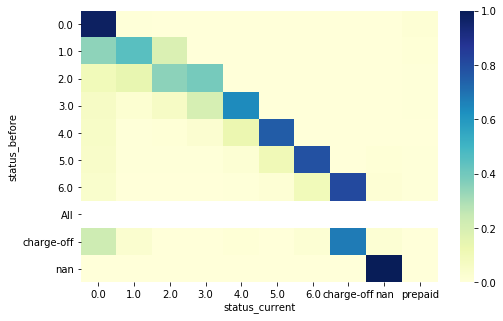

In [85]:
# Draw the heatmap
transition_matrix2 = pd.crosstab(index=perf_delq_prepaid_two_months["status_before"], 
                                 columns=perf_delq_prepaid_two_months['status_current']) # remove margins
transition_matrix2 = transition_matrix2.div(transition_matrix["All"], axis=0)

fig = plt.figure(figsize = (8,5))
sns.heatmap(transition_matrix2,cmap="YlGnBu")

# PROJECT 5 – SURVIVAL ANALYSIS - PREPAID

In [79]:
#perf_delq_prepaid_two_months = perf_delq_prepaid_two_months.rename(columns={'period_seq_end': 'period_seq_before','period_seq_beg': 'period_seq_current'})

print(perf_delq_prepaid_two_months.shape,'\n')
print(perf_delq_prepaid_two_months.info())
perf_delq_prepaid_two_months.head(10)

(3672765, 6) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3672765 entries, 0 to 3672764
Data columns (total 6 columns):
id_loan           object
Period            float64
status_current    object
period_current    float64
status_before     object
period_before     float64
dtypes: float64(3), object(3)
memory usage: 196.1+ MB
None


,id_loan,Period,status_current,period_current,status_before,period_before
0,F108Q1000024,200802.0,0.0,0.0,0.0,NaN
1,F108Q1000024,200803.0,0.0,1.0,0.0,1.0
2,F108Q1000024,200804.0,0.0,2.0,0.0,2.0
3,F108Q1000024,200805.0,0.0,3.0,0.0,3.0
4,F108Q1000024,200806.0,0.0,4.0,0.0,4.0
5,F108Q1000024,200807.0,0.0,5.0,0.0,5.0
6,F108Q1000024,200808.0,0.0,6.0,0.0,6.0
7,F108Q1000024,200809.0,0.0,7.0,0.0,7.0
8,F108Q1000024,200810.0,0.0,8.0,0.0,8.0
9,F108Q1000024,200811.0,0.0,9.0,0.0,9.0


In [87]:
perf_delq_prepaid_two_months['prepaid']=np.where(perf_delq_prepaid_two_months['status_current']=='prepaid', 1, 0)
perf_delq_prepaid_two_months['prepaid'].mean()

0.017148115929007165

In [88]:
# Delete rows with invalid or missing performance period number
perf_pp_sort=perf_delq_prepaid_two_months.loc[~(perf_delq_prepaid_two_months['status_before'].isin(['prepaid']))]

perf_pp_sort=perf_pp_sort[~((perf_pp_sort['period_before'].isna()) | (perf_pp_sort['period_current'].isna()))]
perf_pp_sort=perf_pp_sort[~(perf_pp_sort['Period'].isna())]

perf_pp_sort = perf_pp_sort.reset_index()
perf_pp_sort.head(5)

,index,id_loan,Period,status_current,period_current,status_before,period_before,prepaid
0,1,F108Q1000024,200803.0,0.0,1.0,0.0,1.0,0
1,2,F108Q1000024,200804.0,0.0,2.0,0.0,2.0,0
2,3,F108Q1000024,200805.0,0.0,3.0,0.0,3.0,0
3,4,F108Q1000024,200806.0,0.0,4.0,0.0,4.0,0
4,5,F108Q1000024,200807.0,0.0,5.0,0.0,5.0,0


In [89]:
# Each loan only needs to keep the last performance records
perf_pp_unique = perf_pp_sort.drop_duplicates(['id_loan'], keep='last').reset_index() # This reset_index() can show the original index to column 'level_0'
perf_pp_unique['start_time']=1
print('Prepaid rate for each last performance record:',perf_pp_unique['prepaid'].mean())
perf_pp_unique.head(5)


Prepaid rate for each last performance record: 0.6305462205948739


,level_0,index,id_loan,Period,status_current,period_current,status_before,period_before,prepaid,start_time
0,12,13,F108Q1000024,200903.0,prepaid,13.0,0.0,13.0,1,1
1,20,22,F108Q1000062,200810.0,prepaid,8.0,0.0,8.0,1,1
2,54,57,F108Q1000111,201012.0,prepaid,34.0,0.0,34.0,1,1
3,112,116,F108Q1000197,201212.0,0.0,58.0,0.0,58.0,0,1
4,139,144,F108Q1000222,201005.0,prepaid,27.0,0.0,27.0,1,1


In [90]:
perf_pp_unique=pd.merge(ori[['fico','id_loan']], perf_pp_unique, on='id_loan', how='inner')
    
def fico_band(fico):
    if fico < 600: 
        return '500-599'
    elif fico < 670:
        return '600-669'
    elif fico < 740:
        return '670-739'
    elif fico < 800:
        return '740-799'
    else:
        return '800+'
    
perf_pp_unique['fico_band']=perf_pp_unique['fico'].apply(fico_band)


In [94]:
# conda install -c conda-forge lifelines
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter() 
kmf.fit(durations = perf_pp_unique.period_current, event_observed = perf_pp_unique['prepaid'])


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 91309 total observations, 33154 right-censored observations>

In [96]:
kmf_summary = kmf.event_table.reset_index()
kmf_summary['KM_estimate'] = kmf.survival_function_
kmf_summary.head(12)
# At time 10, about 90.83% of the population is still alive.

,event_at,removed,observed,censored,entrance,at_risk,KM_estimate
0,0.0,0,0,0,91309,91309,1.000000
1,1.0,251,248,3,0,91309,0.997284
2,2.0,392,389,3,0,91058,0.993024
3,3.0,641,639,2,0,90666,0.986025
4,4.0,916,911,5,0,90025,0.976047
5,5.0,998,994,4,0,89109,0.965159
6,6.0,1003,996,7,0,88111,0.954249
7,7.0,1016,990,26,0,87108,0.943404
8,8.0,1033,1000,33,0,86092,0.932446
9,9.0,1096,1062,34,0,85059,0.920804


In [97]:
# Get an idea of loan survival in terms of prepaid --> lifetime value
kmf.predict([1, 3, 6, 12, 18, 24, 36, 48, 60])

1     0.997284
3     0.986025
6     0.954249
12    0.879794
18    0.802509
24    0.726423
36    0.552981
48    0.393308
60    0.306518
Name: KM_estimate, dtype: float64

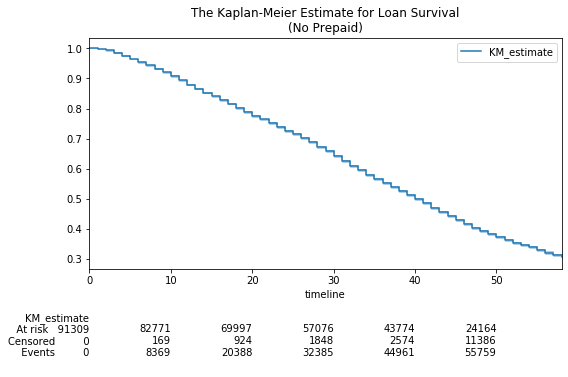

In [98]:
# Plot the KM estimate
fig = plt.figure(figsize = (8,5))
kmf.plot(at_risk_counts=True)

plt.title("The Kaplan-Meier Estimate for Loan Survival\n(No Prepaid)")
plt.ylabel("Probability a Loan is Still in the Portfolio")
plt.show()

          NA_estimate
timeline             
0.0          0.000000
1.0          0.002720
2.0          0.007001
3.0          0.014074
4.0          0.024245
5.0          0.035462
6.0          0.046830
7.0          0.058260
8.0          0.069944
9.0          0.082508


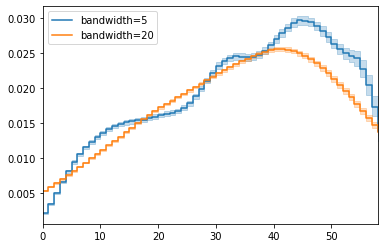

In [100]:
# Another way to summarize and visualize the survival dataset - Estimating hazard rates using Nelson-Aalen
# Rate of survival change
from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()

naf.fit(durations = perf_pp_unique.period_current, event_observed = perf_pp_unique['prepaid'])

print(naf.cumulative_hazard_.head(10))
naf.plot_hazard(bandwidth=5, label='bandwidth=5')
naf.plot_hazard(bandwidth=20,label='bandwidth=20') # the higher bandwidth, the smoother --> Plot the estimate plus the confidence intervals

Text(0.5, 1.0, 'Lifespans of different fico bands')

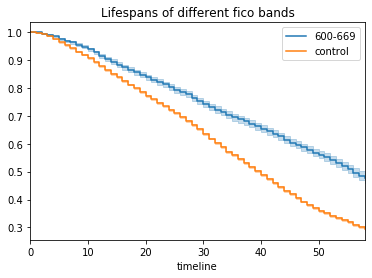

In [102]:
ax = plt.subplot(111)

# Compare survival curve between two groups
T = perf_pp_unique['period_current'] # duration
E = perf_pp_unique['prepaid'] # observed

ix = (perf_pp_unique['fico_band'] == '600-669')

kmf.fit(durations=T[ix], event_observed=E[ix], label='600-669')
kmf.plot(ax=ax)

kmf.fit(durations=T[~ix], event_observed=E[~ix], label='control')
kmf.plot(ax=ax)

plt.title("Lifespans of different fico bands")

In [103]:
# Performing a statistical test for comparing two survival functions
from lifelines.statistics import logrank_test

results = logrank_test(T[ix], T[~ix], E[ix], E[~ix], alpha=.95)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         688.61 <0.005    501.77

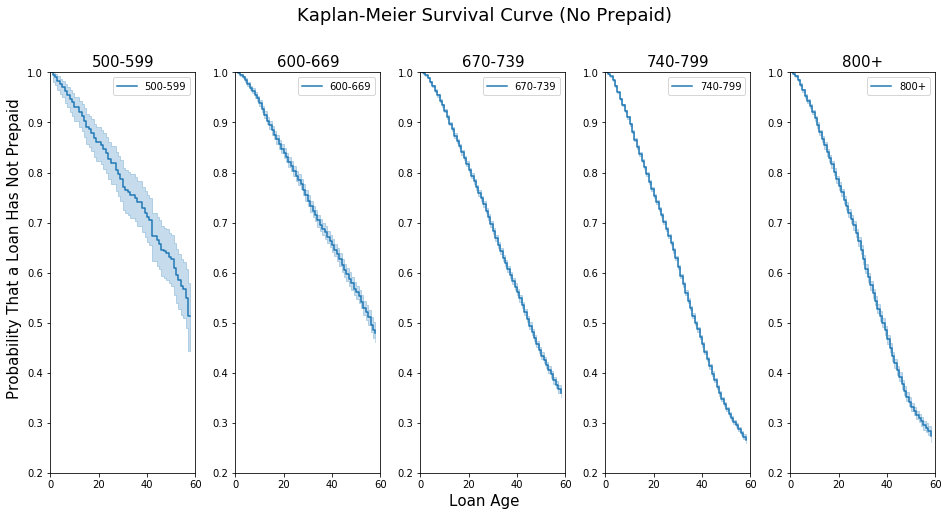

In [104]:
# Compare survival curve between multiple groups
fico_band = perf_pp_unique['fico_band'].unique()
fico_band.sort()
fico_band

fig, axes = plt.subplots(nrows = 1, ncols = 5, sharey = True, figsize=(13,7))

for i, band in enumerate(fico_band):
    ax = plt.subplot(1,5,i+1)
    ix = (perf_pp_unique['fico_band'] == band)
    kmf.fit(T[ix], E[ix], label=band)
    kmf.plot(ax=ax)
    
    plt.title(fico_band[i],fontsize = 15)
    plt.xlim(0, 60)
    plt.ylim(0.2,1)
    ax.set_xlabel("",fontsize=15)

plt.tight_layout()


# Set a common x-axis label
fig.text(0.5, -0.01, "Loan Age", ha="center",fontsize=15) 
# Set a common y-axis label
fig.text(-0.01, 0.5, "Probability That a Loan Has Not Prepaid", va="center", rotation="vertical",fontsize=15) 

# Add the title for the whole plot
fig.suptitle("Kaplan-Meier Survival Curve (No Prepaid)", fontsize=18)
# Add some padding between the title and the rest of the plot to avoid overlap
fig.subplots_adjust(top=0.85)
